In [1]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import ipywidgets as widgets
import sys, os, io, string, shutil, math
from hublib.ui import Submit
from hublib.ui import RunCommand
import hublib.use
%use boost-1.62.0-mpich2-1.3-gnu-4.7.2
%use lammps-31Mar17
%set_env OMP_NUM_THREADS=4
import numpy as np
import re
import time
from threading import Thread
from io import StringIO
from ipywidgets import Layout, Box, Label, Output
from IPython.display import display,HTML
sys.path.append('../python/')
#import train as nn
import random
#from IPython.core.display import display, HTML
display(HTML("<style>.container { width:1310px !important; }</style>"))

style = {'description_width': 'initial'}

left_column='340px'
right_column='940px'
app_width='1282px'
app_height='1360px'

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    padding='5px'
)
box_layout_image=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    #width='25%',
    padding='5px',
    #min_height='20px',
    #min_width='200px'
    width=left_column,
    height='297px'
)
box_layout_phisical=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    #width='25%',
    padding='5px',
    #min_height='20px',
    #min_width='200px'
    width=left_column,
)
box_layout_computing=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=left_column,
)

box_layout_output=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=left_column,
    #height='150px'
)

box_layout_about=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=right_column
)

form_item_layout_tab = Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    justify_content='space-between',
    padding='5px'
)

box_layout_tabs=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=right_column,
    height='100%'
)


button_hide_layout=Layout(
    visibility='hidden', #visible/hidden
    padding='5px',
    
)
button_show_layout=Layout(
    visibility='visible', #visible/hidden
    padding='5px',
    
)

<IPython.core.display.Javascript object>

env: OMP_NUM_THREADS=4


In [2]:
%%html
<style>
.jupyter-widgets.widget-tab > .p-TabBar .p-TabBar-tab {
    flex: 0 1 175px
}
</style>

In [3]:
salt = widgets.BoundedFloatText(
    value=0.5,
    min=0.3,
    max=0.9,
    step=0.1,
    description='Salt concentration (M):',
    style=style
)


In [4]:
pion = widgets.Dropdown(
    options={'1 (monovalent)': 1, '2 (divalent)': 2, '3 (trivalent)': 3},
    value=1,
    description="Positive ion valency (e)",
    style=style
)


In [5]:
nion = widgets.Dropdown(
    options=[-1, -2, -3],
    value=-1,
    description="Negative ion valency (e)",
    style=style
)


In [6]:
clen = widgets.BoundedFloatText(
    value=3,
    min=2,
    max=4,
    step=0.1,
    description='Confinement length (nm):',
    style=style
)


In [7]:
ion_diam_pos = widgets.BoundedFloatText(
    value=.474,
    min=.4,
    max=.7,
    step=0.001,
    description='Positive ion diameter (nm):',
    style=style
)


In [8]:
ion_diam_neg = widgets.BoundedFloatText(
    value=.627,
    min=.4,
    max=.7,
    step=0.001,
    description='Negative ion diameter (nm):',
    style=style
)


In [9]:
steps = widgets.BoundedIntText(
    value=100000,
    min=100000,
    max=5000000,
    step=10000,
    description='Simulation steps:',
    style=style
)


In [10]:
imageSlider = widgets.IntSlider(
    value=0,
    min=0,
    max=0,
    step=10000,
    description='Images',
    style=style
)

In [11]:
submit_str = ''
def onToggleBtnChange(b):
    global submit_str
    if clustorMode.value:
        clustorMode.icon = 'check' 
        clustorMode.button_style = 'success'
        if not submit_str:
            output_image_warning_text.layout.visibility = 'visible'
    else:
        clustorMode.icon = '' 
        clustorMode.button_style=''
        if not submit_str:
            output_image_warning_text.layout.visibility = 'hidden'

clustorMode =widgets.ToggleButton(
    value=False,
    description='Cluster mode',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Simulation will run on a computing cluster when this button is turned on',
    icon='',
    style=style
)

clustorMode.observe(onToggleBtnChange,'value')

In [12]:
play_trigger = False

def play_btn_thread():
    global play_trigger
    imageSlider.value = 0
    while play_trigger:
            imageSlider.value = (imageSlider.value + imageSlider.step) % (imageSlider.max + imageSlider.step)
            time.sleep(1)
    
def onPlayBtnChange(b):
    global play_trigger
    global submit_str
    if playMode.value:
        playMode.button_style = 'success'
        play_trigger = True
        t = Thread(target=play_btn_thread)
        t.start()
        
    else:
        imageSlider.value=0
        playMode.button_style = ''
        play_trigger = False
            

playMode =widgets.ToggleButton(
    value=False,
    description='Play snapshots',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Simulation will run on a computing cluster when this button is turned on',
    icon='',
    style=style
)

playMode.observe(onPlayBtnChange,'value')

In [13]:
#playMode.layout.visibility = 'visible'
#playMode

In [14]:
label_style = "style='background-color: #81c4fd; font-size:500; padding: 2px'"
label_style2 = "style='font-size:350; padding: 2px; font-weight: bold; align: center'"
def make_label(name, label_style, desc="",):
    lval = '<p %s %s>%s</p>' % (desc, label_style, name)
    return widgets.HTML(lval)

plabel = make_label('Physical Parameters', label_style, '')
clabel = make_label('Computing Parameters', label_style, '')
olabel = make_label('Output Controllers', label_style, '')
imageSliderabout = make_label('Slide to navigate the simulation snapshots', label_style2, '')

In [15]:
'''
image_html = widgets.HTML(
    value='<img src="../images/overview.jpg" style="width: 500px"/>',
)
'''
file = open("../images/overview.jpg", "rb")
image = file.read()
image=widgets.Image(
    value=image,
    format='jpg',
    width=320,
    height=297,
)

form_items = [
    Box([image], layout=form_item_layout)
]

mainImage = Box(form_items, layout=box_layout_image)

In [16]:
form_items_p = [
    Box([plabel], layout=form_item_layout),
    Box([salt], layout=form_item_layout),
    Box([pion], layout=form_item_layout),
    Box([nion], layout=form_item_layout),
    Box([clen], layout=form_item_layout),
    Box([ion_diam_pos], layout=form_item_layout),
    Box([ion_diam_neg], layout=form_item_layout)
]

form_items_c = [
    Box([clabel], layout=form_item_layout),
    Box([steps], layout=form_item_layout),
    Box([clustorMode], layout=form_item_layout)
    
]

form_items_output = [
    Box([olabel], layout=form_item_layout),
    Box([imageSlider], layout=form_item_layout),
    Box([imageSliderabout], layout=form_item_layout)
]

physical_para = Box(form_items_p, layout=box_layout_phisical)
computing_para = Box(form_items_c, layout=box_layout_computing)
output_para = Box(form_items_output, layout=box_layout_output)

In [17]:
about=widgets.Textarea(
    value='This app enables users to simulate ions confined between nanoparticle (NP) surfaces in aqueous media. Nanoparticles can be synthetic (such as gold NPs) or natural (e.g. proteins) and the length of confinement is of the order of nanometers. Example systems include ion channel proteins of the cell membrane, adsorbed ions near surfaces of porous electrodes, and ions confined by NPs and/or colloidal particles. NP surfaces are assumed to be unpolarizable and are modeled as planar interfaces considering the large size difference between the ions and the NPs. \nThe app facilitates investigations for a wide array of ionic and environmental parameters. Users can extract the ionic structure (density profile) and study its dependence on salt concentration (c), ion valency (z), and other physical attributes. \nUsers can explore interesting effects by changing the c parameter from 0.3 to 0.9 M. This increase in density leads to crowding of the channel (confinement) with a large number of ions. The effect of symmetry breaking caused by the surfaces is seen: to avoid being pushed by ions from both the sides, an ion prefers the interface over the central region (bulk). The app enables users to explore this effect of ion accumulation near the interface, and make a quantitative assessment of ionic structure in strong confinement.\nAnother rich avenue to explore is to tune the valency of positive ions (parameter z) from 1 to 3. A positively-charged multivalent ion (+3 Fe or +2 Ca) near an interface is pulled away from the interface by oppositely charged ions with a stronger force relative to the bulk where the symmetry allows for no preferred movement. Thus, stronger electrostatic interactions (as in the case of multivalent ions) tend to cause depletion of the ions from the interface. This app empowers users to investigate this depletion effect via accurate computation of the density profiles of ions. \nEffects of changing other physical attributes such as confinement length and ion size are also available for users to explore. We invite users to take an inside look at what happens to the self-assembly of ions in these nanoscale channels by investigating the interplay of electrostatic effects and steric (or entropic) effects caused due to confinement, and measuring associated density profiles. \nWhile we provide a default of 20000 steps for users to get started on exploring different features of the app by obtaining immediate results, converged results of smooth profiles are expected for around 1 million steps. Users are given the option of clicking on "Cluster mode" button for accessing supercomputing resources to lower the computing time (however, they must allow for queue wait times that may vary). Simulation of confined ions is performed using LAMMPS and pre- and post-processing is carried out using the in-house C++ code. ',
    placeholder='',
    layout={'height': '225px','width': '100%'},
    disabled=True,
    style = {'font_weight': '150px'}
)

form_about = [
    Box([about], layout=form_item_layout)
]

about_text = Box(form_about, layout=box_layout_about)


In [18]:
def clear_All():
    localOutput.value = ""
    submit_str= ''
    progressBar.value=0
    imageSlider.max=0
    imageSlider.value=0 
    plt.figure('Distribution of positive ions')
    plt.clf()  # clear old plot
    plt.figure('Distribution of negative ions')
    plt.clf()  # clear old plot
    playMode.value = False
    playMode.layout.visibility = 'hidden'
    
    movie_download.layout = postive_den_download.layout = negative_den_download.layout = button_hide_layout
    
    output_image.value=imageEmptyBox
    
    if clustorMode.value:
        output_image_warning_text.layout.visibility = 'visible'
    else:
        output_image_warning_text.layout.visibility = 'hidden'
    

In [19]:
def runPreprocessor(z_value, p_value, n_value, c_value, d_value, a_value, s_value):
    preprocessingCMD = "./md_simulation_confined_ions " + "-Z "+str(z_value)+" -p "+str(p_value)+" -n "+str(n_value)+" -c "+str(c_value)+" -d "+str(d_value)+" -a "+str(a_value)+" -S "+str(s_value)+" -J true -j true > preprocessor.log"
    
    try:
        !$preprocessingCMD
        
    except  Exception as e:
        sys.stderr.write('Error occured during the execution of preprocessing executable')
        sys.stderr.write(str(e))
        sys.exit(1)

In [20]:

runFlag=False
working_dir=""
parameter_append=""
sim_bigin=False
build_Plots=True
simulation_params=""
simulationStepsToatal=0

def callExe(s):
    global runFlag, working_dir, parameter_append, sim_bigin, ionsplot, build_Plots, simulation_params, simulationStepsToatal
    global clen_value, pion_value, nion_value, salt_value, ion_diam_value_pos, ion_diam_value_neg, sim_steps_value
    global submit_str
    if build_Plots:
        showPlotUI()
        build_Plots = False
        
    clear_All()
    
    localOutput.value = localOutput.value + "Simulation begins...\n"    
    
    salt_value = salt.value
    pion_value = pion.value
    nion_value = nion.value
    clen_value = clen.value
    ion_diam_value_pos = ion_diam_pos.value
    ion_diam_value_neg = ion_diam_neg.value
    sim_steps_value = steps.value
    walltime = 10
    mpi_processors = 4
    total_processors = 16
    grid_points = 752
    simulationStepsToatal = sim_steps_value
    stepFactor = 1
    addFactor = 1
    
    if simulationStepsToatal < 100000:
        total_processors = 16
        stepFactor = int((simulationStepsToatal+(10000-1))/10000)
        addFactor = 0
    elif simulationStepsToatal < 500000:
        total_processors = 32
        stepFactor = int((simulationStepsToatal+(100000-1))/100000)
        addFactor = 0
    elif simulationStepsToatal < 1000000:
        total_processors = 64
        stepFactor = int((simulationStepsToatal+(500000-1))/500000)
        addFactor = 0
    else:
        total_processors = 64
        stepFactor = int((simulationStepsToatal+(1000000-1))/1000000)*3
        addFactor = 0
    
    #total_processors=str(int(mpi_processors*mpi_processors))

    walltime=str(int(total_processors/16)+stepFactor+addFactor)
    
    
    #Adding standard outputs to string to be sent to output widget callback function
    parameter_append= "Salt concentration is "+ str(salt_value)+"\n"
    parameter_append= parameter_append + "Positive valency is "+ str(pion_value)+"\n"
    parameter_append= parameter_append + "Negative valency is "+ str(nion_value)+"\n"
    parameter_append= parameter_append + "Confinement length is "+ str(clen_value)+"\n"
    parameter_append= parameter_append + "Positive ion diameter is "+ str(ion_diam_value_pos)+"\n"
    parameter_append= parameter_append + "Negative ion diameter is "+ str(ion_diam_value_neg)+"\n"
    parameter_append= parameter_append + "Simulation steps is "+ str(sim_steps_value)+"\n"
    
    if clustorMode.value:
        parameter_append= parameter_append + "Requested walltime is "+ str(walltime)+" (mins)\n"
        parameter_append= parameter_append + "Requested total processors are "+ str(total_processors)+"\n"
    
    simulation_params="_%.2f" % float(clen_value)+"_%d" % int(pion_value)+"_%d" % int(nion_value)+"_%.2f" % float(salt_value)+"_%.3f" % float(ion_diam_value_pos)+"_%.3f" % float(ion_diam_value_neg)+"_%d" % int(sim_steps_value)

    shutil.rmtree('data',True)
    if not os.path.exists('data'):
        os.makedirs('data')

    shutil.rmtree('outfiles',True)
    if not os.path.exists('outfiles'): 
        os.makedirs('outfiles')
        
    localOutput.value = localOutput.value + "Preprocessing is running...\n"
    
    #preprocessing stage
    runPreprocessor(clen_value, pion_value, nion_value, salt_value, ion_diam_value_pos, ion_diam_value_neg, sim_steps_value)   
    
    localOutput.value = localOutput.value + "Preprocessing completed\n"
        
    localOutput.value = localOutput.value +  parameter_append;   
    

    # forcing OpenMP thread size, comment when deploying
    #os.environ["OMP_NUM_THREADS"] = "4"
    #os.environ["OMP_NUM_THREADS"] = "2"

    runName='nanoconfine'
    
    #computing_clusters = ['standby@conte','standby@rice']
    computing_clusters = ['standby@rice']
    
    #cluster_name = computing_clusters[random.randint(0,1)]
    cluster_name = computing_clusters[0]
    
    submit_para_list = '--venue ' + str(cluster_name) + ' -w '+ str(walltime)+' -n '+str(total_processors) \
    + ' -N ' + '16 ' + ' --tailStdout 1000 ' + '--inputfile ' + 'data ' + 'nanoconfinement-r32 '
    
    
    prog_paraList = ' -Z ' + str(clen_value) + ' -p ' + str(pion_value) + ' -n ' + str(nion_value) + ' -c ' + str(salt_value) \
    + ' -d ' + str(ion_diam_value_pos)+ ' -a ' + str(ion_diam_value_neg) + ' -S ' + str(sim_steps_value) + ' -f ' + str(simulation_params) + ' -v ' + 'false'

    
    runFlag=True
    sim_bigin=True
    
    #starting a thread for on the fly density plot
    #t2 = Thread(target=iterative_density_plot)
    #t2.start()
    
    try:
        submit_str = ""
        
        if clustorMode.value:
            submit_str = '--venue standby@brown -n '+str(total_processors)+' -N 16'+' -w '+str(walltime)+' -e OMP_NUM_THREADS=1'+' --tailStdout 1000 ' +'--inputfile '+'outfiles '+'lammps-31Mar17-parallel -in in.lammps'
            #submit_str = '-n '+str(total_processors)+' -w '+str(walltime)+' -N 20'+' -e OMP_NUM_THREADS=1'+' --tailStdout 1000 ' +'--inputfile '+'outfiles '+'lammps-31Mar17-parallel -in in.lammps' 
            #submit_str = '--venue standby@rice ' + '-n 32 -w 60 -N 16'+' --tailStdout 1000 ' +'--inputfile '+'outfiles '+'lammps-31Mar17-parallel -in in.lammps'
            localOutput.value = localOutput.value + "LAMMPS input script designed and simulation submitted to the cluster, waiting for response...\n"
        else:
            submit_str = '--local stdbuf -o0 -e0 lmp_serial -in in.lammps'
            localOutput.value = localOutput.value + "LAMMPS input script designed and simulation running...\n"
        #rname = s.make_rname(e_np_value, e_out_value, pion_value, c_out_value, np_radius_value, np_charge_value, sim_steps_value)
        #run_str = 'stdbuf -o0 -e0 lmp_serial -in in.lammps' 
        
        #submit_str = submit_para_list + prog_paraList
        #parameter_append= parameter_append + "Running the simulation on "+ str(cluster_name)+"\n"
        
        #submit_str = '--local pwd'
        s.run(runName, submit_str)
        
        time.sleep(1)
           
        
    except  Exception as e:
        sys.stderr.write('Error occured during the execution of md_simulation_confined_ions')
        sys.stderr.write(str(e))
        sys.exit(1)
    
    time.sleep(1)
    runFlag = False
    #t2.join()

        
 
  

In [21]:
def doneFunc(s, rdir):
    global submit_str  
    submit_str = ""
    progressBar.value=int(100)
    playMode.layout.visibility = 'visible'
    
    localOutput.value = localOutput.value + "LAMMPS simulation finished\n" 
    
    submit_btn.but.disabled = True
    
    localOutput.value = localOutput.value + "Postprocessing is running...\n"
    
    #postprocessing stage
    try:
        postprocessingCMD = "./md_simulation_confined_ions " + "-Z "+str(clen_value)+" -p "+str(pion_value)+" -n "+str(nion_value)+" -c "+str(salt_value)+" -d "+str(ion_diam_value_pos)+" -a "+str(ion_diam_value_neg)+" -S "+str(sim_steps_value)+" -J true -j false > postprocessor.log"
        !$postprocessingCMD
        
    except  Exception as e:
        print(str(e))
        sys.stderr.write('Error occured during the execution of postprocessing executable')
        sys.stderr.write(str(e))
        sys.exit(1) 
        
    localOutput.value = localOutput.value + "Postprocessing is finished\n"
    
    #  Plotting the result
    plot_data()
    
    localOutput.value = localOutput.value + "Simulation ended\n"
    
    submit_btn.but.disabled = False
    
    movie_download.layout = postive_den_download.layout = negative_den_download.layout = button_show_layout

    

In [22]:
# after the run finished, optionally do something
# with the output
def plot_data():
    #We ignore rdir because submit puts non-parametric runs in the current directory
    # When caching is enabled, they get put in a chached directory and rdit is always used. 
    #wait for 2 seconds before plotting errorBars.
    time.sleep(2)
    plt.figure('Distribution of positive ions')
    plt.clf()  # clear old plot
    plt.title('Distribution of positive ions confined within the nanoparticle surfaces')
    plt.xlabel('Distance between the two surfaces (z = 0 is the midpoint) (nm)', fontsize=10)
    plt.ylabel('Density (M)', fontsize=10)
    
    # our simulation writes to outfiles -> density_profile.dat
    try:
        density_profile = np.loadtxt(working_dir + 'data/p_density_profile.dat')
    except:
        sys.stderr.write('Can not find the positive density results file')
        sys.exit(1)
    #print(density_profile)    
    x = density_profile[:,0]
    y = density_profile[:,1]
    yrr = density_profile[:,2]
    plt.errorbar(x,y,xerr=0.0, yerr=yrr, c='b', ecolor='r', capsize=2)
    
    plt.show()
    
    plt.figure('Distribution of negative ions')
    plt.clf()  # clear old plot
    plt.title('Distribution of negative ions confined within the nanoparticle surfaces')
    plt.xlabel('Distance between the two surfaces (z = 0 is the midpoint) (nm)', fontsize=10)
    plt.ylabel('Density (M)', fontsize=10)
    
    # our simulation writes to outfiles -> density_profile.dat
    try:
        ndensity_profile = np.loadtxt(working_dir + 'data/n_density_profile.dat')
    except:
        sys.stderr.write('Can not find the negative density results file')
        sys.exit(1)
    #print(ndensity_profile)    
    x = ndensity_profile[:,0]
    y = ndensity_profile[:,1]
    yrr = ndensity_profile[:,2]
    plt.errorbar(x,y,xerr=0.0, yerr=yrr, c='b', ecolor='r', capsize=2)
    
    plt.show()

In [23]:
in_wrapper_progress = False
saved_data = ""
saved_data_enery = ""
saved_data_ions_pos = ""
stepNumber = 0
def stdoutput_handler(buffer):
    global submit_str
    global in_wrapper_progress, saved_data, parameter_append, sim_bigin, stepNumber, saved_data_enery, saved_data_ions_pos
    output = []
    
    #return buffer
    
    if sim_bigin:
        #output.append(parameter_append)
        sim_bigin = False
   
    data = buffer.split('\n')
    last = len(data) - 1
    
    for i, line in enumerate(data):
        
        output.append(line)
        
        if line.startswith('Loop time of '):
            in_wrapper_progress = False
            continue
        
        if in_wrapper_progress:
            number = line.split()
            if number:
                if number[0].isdigit():
                    #print(number[0])
                    percent = float(number[0])/simulationStepsToatal*100
                    progressBar.value=int(percent)
                    #print(percent)
                    if submit_str.startswith('--local '):
                        if(int(number[0])%imageSlider.step == 0):
                            imageSlider.max=number[0]
                            imageSlider.value=number[0] 
            continue
        
        if line.startswith('Step Temp Volume Density KinEng PotEng TotEng'):
            in_wrapper_progress = True
            
            
    reduced_buffer = '\n'.join(output)
    
    #appending new line at the end
    if reduced_buffer:
        if reduced_buffer[-1] != '\n':
            reduced_buffer = reduced_buffer + '\n'
    
    
    return reduced_buffer

In [24]:
#button_style = "style='background-color: #81c4fd; font-size:500; padding: 4px; -webkit-appearance: button; -moz-appearance: button; appearance: button; text-decoration: none; color: initial;'"

def make_downloadBtn(downFilename="", downloadURL="", displayText=""):
    bval = "<a download='%s' href='%s'><button class='p-Widget jupyter-widgets jupyter-button widget-button mod-info'>%s</button></a>" % (downFilename, downloadURL, displayText)
    return widgets.HTML(bval)

#from IPython.display import FileLink, FileLinks
#FileLinks('outfiles')
#FileLinks('data')

<IPython.core.display.Javascript object>


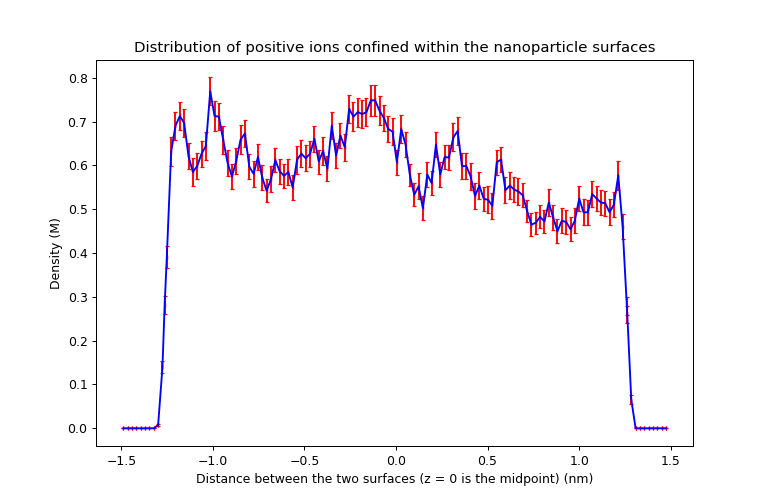

<IPython.core.display.Javascript object>


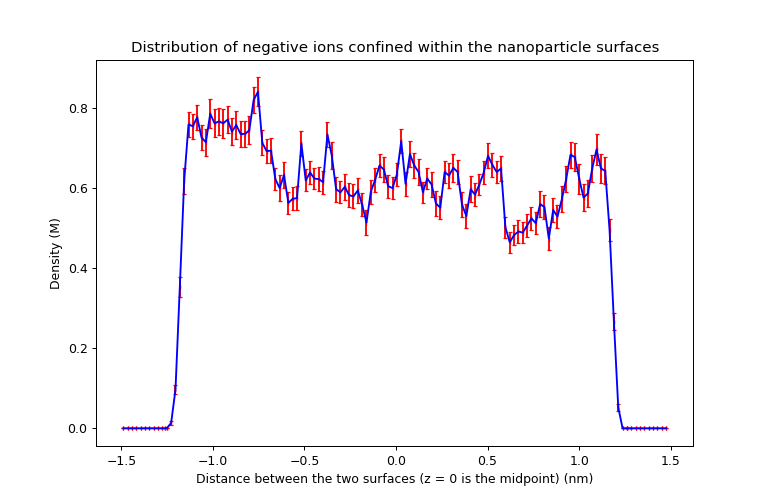

In [25]:
tab_layout=Layout(
    #width='100%',
    height='643.5px',
    justify_content='space-between',
)

# we want the plot to go here, so create an empty one initially
#create tabs
figsize_tup=(8.60, 5.60)
figure_density_pos = plt.figure(num='Distribution of positive ions', figsize=figsize_tup)
out_desnity_pos = Output(layout=tab_layout)

figure_density_neg = plt.figure(num='Distribution of negative ions', figsize=figsize_tup)
out_desnity_neg = Output(layout=tab_layout)

file = open("../images/image.emptybox.jpg", "rb")
imageEmptyBox = file.read()

output_image=widgets.Image(
    format='jpg',
    width=615,
    #height=650,
    value=imageEmptyBox
)

#figure_density_both = plt.figure(num='Distribution of positive/negative ions', figsize=figsize_tup)
#out_desnity_both = Output(layout=tab_layout)

output_image_layout=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    margin = '0px 0px 0px 50px' #top, right, bottom and left
)

box_layout_warning_text=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 1px',
    align_items='stretch',
    padding='5px',
    width='150px',
    visibility = 'hidden',
    height='95%'
)
box_layout_playbtn=Layout(
    display='flex-end',
    flex_flow='row',
    #border='solid 1px',
    align_items='stretch',
    padding='5px',
    width='150px',
    visibility = 'hidden',
    #height='136px'
)


#label_style3 = "style='background-color: #eeeeee; color: #388e3c; font-size:350; padding: 2px; font-weight: bold; align: center'"
label_style3 = "style='background-color: #eeeeee; font-size:350; padding: 2px; font-weight: bold; align: center'"
output_image_warning_text = make_label('Cluster mode is on! You will lose access to the dynamic simulation snapshot data. Snapshot data will be available at the end of simulation.', label_style3, '')



box_layout_for_right = Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    #border='solid',
    height='100%',
    #width='150px',
    #width='50%'
)

form_output_image_sec_right_items = [
    Box([output_image_warning_text], layout=box_layout_warning_text),
    Box([playMode], layout=box_layout_playbtn),

]

form_output_image_sec_right = Box(form_output_image_sec_right_items, layout=box_layout_for_right)

output_image_box =  Box([output_image], layout=output_image_layout)

form_output_image_sec = [
    Box([output_image_box], layout=output_image_layout),
    Box([form_output_image_sec_right], layout=box_layout_for_right),

]
output_image_section = Box(form_output_image_sec, layout=tab_layout)

#download button
movie_download = make_downloadBtn(downFilename="electrolyte_movie.xyz", downloadURL="outfiles/electrolyte_movie.xyz", displayText="Movie")
postive_den_download = make_downloadBtn(downFilename="p_density_profile.dat", downloadURL="data/p_density_profile.dat", displayText="Positive ion density")
negative_den_download = make_downloadBtn(downFilename="n_density_profile.dat", downloadURL="data/n_density_profile.dat", displayText="Negative ion density")

movie_download.layout = postive_den_download.layout = negative_den_download.layout =  button_hide_layout

box_layout_outputs=Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    padding='5px'
)

form_output_content = [
    Box([movie_download], layout=box_layout_outputs),
    Box([postive_den_download], layout=box_layout_outputs),
    Box([negative_den_download], layout=box_layout_outputs)
]
downloadMovieSec = Box(form_output_content, layout=tab_layout)


In [26]:
#tabChange detection and plot data incase automatically not drawn
def onTabChange(b):
    if os.path.isfile('data/p_density_profile.dat') and os.path.isfile('data/n_density_profile.dat'):
        plot_data()

In [27]:
def onSliderChange(b):
    
    value = imageSlider.value
    valueText = str(value)
    if value==0:
        valueText = "000"
    
    fileName="image."+valueText+".jpg"
    fileName="outfiles/"+fileName;
    try:
        file = open(fileName, "rb")
        selectedImage = file.read()
        output_image.value=selectedImage
    except:
        sys.stderr.write('Image file is not there yet.')
       
    
imageSlider.observe(onSliderChange, names='value')

In [28]:
tab_contents = ['Positive Ion Density', 'Negative Ion Density', 'Simulation Snapshot', 'Downloads']
children = [out_desnity_pos, out_desnity_neg, output_image_section, downloadMovieSec]
tabSpace = widgets.Tab()
tabSpace.children = children
for i in range(len(children)):
    tabSpace.set_title(i, str(tab_contents[i]))
tabSpace.selected_index = 2

tabSpace.observe(onTabChange, names='selected_index')

form_tab_content = [
    Box([tabSpace], layout=form_item_layout_tab)
]

tab = Box(form_tab_content, layout=box_layout_tabs)

In [29]:
def showPlotUI():
    with out_desnity_pos:
        display(figure_density_pos, layout=tab_layout)
    with out_desnity_neg:
        display(figure_density_neg, layout=tab_layout)  

In [30]:
form_item_layout_output = Layout(
    display='flex',
    flex_flow='column',
    justify_content='space-between',
    padding='4px'
)

form_item_layout_run_btn = Layout(
    display='flex',
    flex_flow='column',
    justify_content='space-between',
    padding='4px'
)

#Submit(start_func=callExe, done_func=plot_data, cachename='SubmitTest1')
submit_btn=Submit(start_func=callExe, done_func=doneFunc, outcb=stdoutput_handler)
#submit_btn=RunCommand(start_func=callExe, done_func=doneFunc, outcb=stdoutput_handler)
submit_btn.acc.set_title(0, "LAMMPS Output")
submit_btn.w.layout = form_item_layout_run_btn
#submit_btn.acc.layout = form_item_layout_output
localOutput = widgets.Textarea(layout={'width': '100%', 'height': '250px'})
localOutputWidget = widgets.Accordion(children=[localOutput],layout=form_item_layout_output)
localOutputWidget.set_title(0, "Output")
localOutputWidget.selected_index = None
localOutput.value = ""
#vars(submit_btn)


In [31]:
progressBar=widgets.IntProgress(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Progress:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal',
    layout={'width': '100%'},
    style=style
)

form_items_progress = [
    Box([progressBar], layout=form_item_layout)
]

progressBar_Ele = Box(form_items_progress, layout=box_layout_computing)

In [32]:
form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    padding='5px'
)

box_layout_column_left=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=left_column,
)
box_layout_column_right=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=right_column
)

box_layout=Layout(
    display='flex',
    flex_flow='row',
    #border='solid 2px',
    align_items='stretch',
    width=app_width,
    #padding='5px',
    height='1000px'
)

box_layout_rows=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=app_width,
    #padding='5px',
    height='1900px'#'1770px',
    #overflow_x='scroll',
    #overflow=None
)


gui_left = [
    Box([mainImage], layout=form_item_layout),
    Box([physical_para], layout=form_item_layout),
    Box([computing_para], layout=form_item_layout),
    Box([progressBar_Ele], layout=form_item_layout),
    Box([output_para], layout=form_item_layout)
]

gui_right = [
    Box([about_text], layout=form_item_layout),
    Box([tab], layout=form_item_layout)
]

form_left = Box(gui_left, layout=box_layout_column_left)
form_right = Box(gui_right, layout=box_layout_column_right)

gui_upper = [
    Box([form_left], layout=box_layout_column_left),
    Box([form_right], layout=box_layout_column_right)
]

form = Box(gui_upper, layout=box_layout)

gui = widgets.VBox([form,localOutputWidget,submit_btn.w],layout=box_layout_rows)


In [33]:
gui

VBox(children=(Box(children=(Box(children=(Box(children=(Box(children=(Box(children=(Box(children=(Image(value=b'\xff\xd8\xff\xe1+"Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x0c\x01\x00\x00\x03\x00\x00\x00\x01\t$\x00\x00\x01\x01\x00\x03\x00\x00\x00\x01\x07\xb4\x00\x00\x01\x02\x00\x03\x00\x00\x00\x03\x00\x00\x00\x9e\x01\x06\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x01\x15\x00\x03\x00\x00\x00\x01\x00\x03\x00\x00\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00\xa4\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00\xac\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x011\x00\x02\x00\x00\x00"\x00\x00\x00\xb4\x012\x00\x02\x00\x00\x00\x14\x00\x00\x00\xd6\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00\xec\x00\x00\x01$\x00\x08\x00\x08\x00\x08\x00-\xc6\xc0\x00\x00\'\x10\x00-\xc6\xc0\x00\x00\'\x10Adobe Photoshop CC 2017 (Windows)\x002017:12:21 22:16:58\x00\x00\x00\x00\x04\x90\x00\x00\x07\x00\x00\x00\x040221\xa0\x01\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\xa0\x02\x00\x04\x00\x00\x00\x01\x00\x00\x03\xe8\xa0\x03\x00\x04\x00\x00\x00\x01\x00\x00\x03\xa0\x00\x00\x00\x00\x00\x00\x00\x06\x01\x03\x00\x03\x00\x00\x00\x01\x00\x06\x00\x00\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x01r\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x01z\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x02\x01\x00\x04\x00\x00\x00\x01\x00\x00\x01\x82\x02\x02\x00\x04\x00\x00\x00\x01\x00\x00)\x98\x00\x00\x00\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x01\xff\xd8\xff\xed\x00\x0cAdobe_CM\x00\x01\xff\xee\x00\x0eAdobe\x00d\x80\x00\x00\x00\x01\xff\xdb\x00\x84\x00\x0c\x08\x08\x08\t\x08\x0c\t\t\x0c\x11\x0b\n\x0b\x11\x15\x0f\x0c\x0c\x0f\x15\x18\x13\x13\x15\x13\x13\x18\x11\x0c\x0c\x0c\x0c\x0c\x0c\x11\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x01\r\x0b\x0b\r\x0e\r\x10\x0e\x0e\x10\x14\x0e\x0e\x0e\x14\x14\x0e\x0e\x0e\x0e\x14\x11\x0c\x0c\x0c\x0c\x0c\x11\x11\x0c\x0c\x0c\x0c\x0c\x0c\x11\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\xff\xc0\x00\x11\x08\x00\x94\x00\x9f\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xdd\x00\x04\x00\n\xff\xc4\x01?\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x03\x00\x01\x02\x04\x05\x06\x07\x08\t\n\x0b\x01\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x10\x00\x01\x04\x01\x03\x02\x04\x02\x05\x07\x06\x08\x05\x03\x0c3\x01\x00\x02\x11\x03\x04!\x121\x05AQa\x13"q\x812\x06\x14\x91\xa1\xb1B#$\x15R\xc1b34r\x82\xd1C\x07%\x92S\xf0\xe1\xf1cs5\x16\xa2\xb2\x83&D\x93TdE\xc2\xa3t6\x17\xd2U\xe2e\xf2\xb3\x84\xc3\xd3u\xe3\xf3F\'\x94\xa4\x85\xb4\x95\xc4\xd4\xe4\xf4\xa5\xb5\xc5\xd5\xe5\xf5Vfv\x86\x96\xa6\xb6\xc6\xd6\xe6\xf67GWgw\x87\x97\xa7\xb7\xc7\xd7\xe7\xf7\x11\x00\x02\x02\x01\x02\x04\x04\x03\x04\x05\x06\x07\x07\x06\x055\x01\x00\x02\x11\x03!1\x12\x04AQaq"\x13\x052\x81\x91\x14\xa1\xb1B#\xc1R\xd1\xf03$b\xe1r\x82\x92CS\x15cs4\xf1%\x06\x16\xa2\xb2\x83\x07&5\xc2\xd2D\x93T\xa3\x17dEU6te\xe2\xf2\xb3\x84\xc3\xd3u\xe3\xf3F\x94\xa4\x85\xb4\x95\xc4\xd4\xe4\xf4\xa5\xb5\xc5\xd5\xe5\xf5Vfv\x86\x96\xa6\xb6\xc6\xd6\xe6\xf6\'7GWgw\x87\x97\xa7\xb7\xc7\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x03\x11\x00?\x00\xf4\xdb\xf2-m\xad\xa2\x8a\xc5\x96\xb8\x17;s\xb6\xb5\xad\x1an{\x83lw\xb9\xdf\xcd\xb3b\xae:\x8d\x86\xba\xed\x16b\x1a\xed\x7f\xa5S\xc5\xfe\xd7XIo\xa5[\xbd?}\x9b\x9b\xf4\x11\x9b\xff\x00)Y\xff\x00\x10\xcf\xfa\xbbW?\x87\xf5K.\x86\xe31\xf6Tk\xc7u\x17\x9a\x81v\xdf\xb4\xb2\xca>\xd5{}\x8d\xfax\x98\xbbj\xff\x00\x86\xc9\xc8\xfa\x08\xe4\x91\x87\x08\x8c\x04\xacY&\xd9\xf9|Xf$r\xe5\xf6\xf8LxE_\x10<\\_\xf7\x0fC\xbb\xa8\xff\x00\xa2\xa7\xfe\xdcw\xfe\x91B\xa73&\xfa\x06E\x1ff\xb2\x93$X\xdb\\[\xa1\xda\xefw\xa5\xf9\xbbV\x15\xbd\'\xa9\xe1\xd1\x91ffm\x15\xd6\xe7W\xea:\xdb\xdf[r6\xdcn\xb2\xcc\x8b\\\xdf\xd4_f6\xda=<oW\xf7?\x99\xf4\xd0zU4\xbb\'\x02\x9a\xfa\x9e%\xe7\x1e\xb6\xb7\xd3\xc7\xcbi\x87\x87d:\xe6\xb6\x83U\xae\xc8\xa7%\xb7\xd3\xeb~\x92\x8b?C\xff\x00\x07Zh\xc93\xaf\xb3\xa7S\xeae<